# Kaggle Competition: Digit Recognizer
link: [kaggle competition](https://www.kaggle.com/c/digit-recognizer/overview)

In [1]:
from kaggle_dr_utls import *

In [2]:
PATH_DATA = Path('.')

In [36]:
#!chmod 600 /home/marcau/.kaggle/kaggle.json
#!kaggle competitions download -c digit-recognizer

Import data

In [4]:
data = pd.read_csv(PATH_DATA / "train.csv")
test = pd.read_csv(PATH_DATA / "test.csv")

In [5]:
data.shape, test.shape

((42000, 785), (28000, 784))

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
target = data.label
train = data.drop('label', axis=1)

Check for missing data

In [8]:
assert (train.isnull().sum().sum() == 0), "there are missing entries"

In [9]:
np.random.seed(10)

Let's plot some of the data

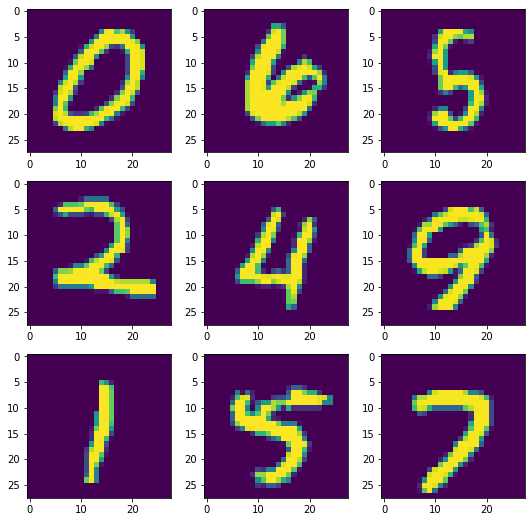

In [10]:
fig, ax = plot_img(train)

We can use PCA to reduce the dimensionality of the input and see how different models perform in both cases.

In [11]:
dims = np.arange(15, 121, 15).astype(int)

exp_var = []
for dim in dims: 
    print(f'components: {dim}')
    svd = TruncatedSVD(n_components=dim, n_iter=5, random_state=10)
    svd.fit(train)
    exp_var.append(svd.explained_variance_ratio_.sum())

components: 15
components: 30
components: 45
components: 60
components: 75
components: 90
components: 105
components: 120


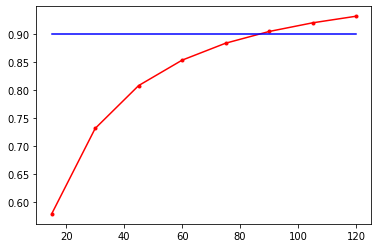

In [12]:
plt.plot(dims, exp_var, 'r.-')
plt.plot([15, 120], [0.90, 0.90], 'b-')

In [13]:
#Find the minimum number of components that explain more than 90% of the variance
#argmax returns the argmax of the minimum value for which the condition holds
min_num_components = dims[np.argmax(np.array(exp_var) > 0.9)]

In [14]:
pca = PCA(n_components=min_num_components)
train_tr = pca.fit_transform(train)
train_tr_back = pca.inverse_transform(train_tr)

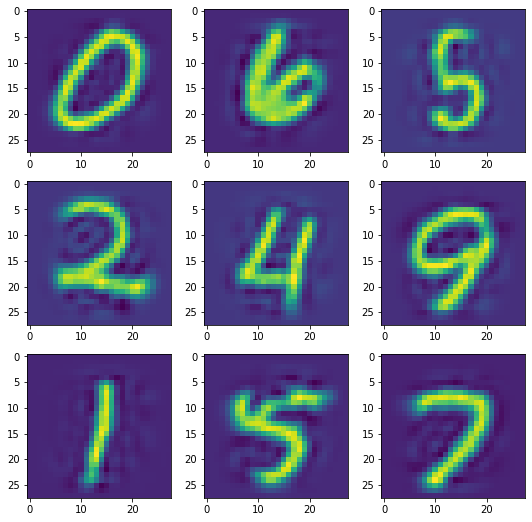

In [15]:
fig, ax = plot_img(train_tr_back)

Let's now use Random Forest on the reduced dataset

In [16]:
model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(train_tr, target, \
                test_size=0.25, random_state=10)

model.fit(train_tr, target)

print(f'train score: {model.score(X_train, y_train)}\ntest score: {model.score(X_test, y_test)}')

train score: 1.0
test score: 1.0


In [17]:
assert create_subfile_dr(test, pca, model) == 0, 'something went wrong with the submission'

0

In [24]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{model}.csv" -m 'submission of {model} model'

  4%|█▌                                     | 8.00k/208k [00:00<00:04, 50.0kB/s]^C
100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 68.7kB/s]
User cancelled operation
